In [191]:
# In the previous notebook, we got 3 csv files for (1) during, (2) before and (3) after - 
# with the statistics for our three environmental variables: temp, Secchi and Chlorophyll-a.
# In this notebook, this data will be standardised and plotted, so that the anomalies could be compared between the different periods. 
# The order of the analysis would be the same starting with during the cyclone period, then before and lastly after. 

In [205]:
# load the necessary packages 

import os
import scipy
import shutil
import numpy as np
import pandas as pd
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config['data_dir'] = os.getenv('CARTOPY_DIR', cartopy.config.get('data_dir'))

import plotly.express as px
import geopandas as gpd
from scipy.spatial import cKDTree

import imageio
import os
import io
import requests

import datetime as dt
from dateutil.relativedelta import *

import netCDF4
from netCDF4 import Dataset, num2date

import cmocean

import seaborn as sns
import pymannkendall as mk

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from matplotlib import pyplot as plt
%matplotlib inline

from PIL import Image  # To create gifs
from shapely.geometry import Point
from shapely.geometry import LineString

In [391]:
# Loding the cvs with all the stats for all positions and stats for During the cyclone period 
combined_stats_DURING = pd.read_csv('combined_stats_DURING.csv')
combined_stats_DURING

,Unnamed: 0,var_name,position,stats,Day 22,Day 23,Day 24,Day 25,Day 26,Day 27,Day 28,Day 29,Day 30
0,0,temp,pos4,Mean,30.452438,30.304798,29.783731,29.542430,29.346487,29.207323,29.068980,29.126822,29.378609
1,1,temp,pos4,Max,30.649218,30.611778,30.001358,29.683575,29.465958,29.295725,29.155552,29.307812,29.504040
2,2,temp,pos4,Min,30.110304,29.974293,29.457851,29.333520,29.189405,29.037859,28.946226,28.961296,29.231780
3,3,temp,pos5,Mean,30.368689,30.254457,29.811983,29.473957,29.264202,29.130770,29.010042,29.010029,29.255510
4,4,temp,pos5,Max,30.649218,30.611778,30.013517,29.621355,29.465958,29.275011,29.162775,29.289953,29.492980
...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,202,Chl,pos35,Max,0.068210,0.058190,0.057333,0.053044,0.042135,0.043165,0.039545,0.036130,0.039129
203,203,Chl,pos35,Min,0.027515,0.025786,0.022868,0.021744,0.017938,0.015646,0.013920,0.012721,0.019063
204,204,Chl,pos36,Mean,0.028977,0.029192,0.028755,0.030848,0.028296,0.028486,0.028939,0.031232,0.034393
205,205,Chl,pos36,Max,0.032690,0.038512,0.042875,0.044485,0.034882,0.036477,0.034582,0.036198,0.039238


In [209]:
# Now, we want to adjust the positions (i.e., column 'MeanTemp') to match the days of cyclonic activity, 
# so that each position will correspond with the  day that the cyclone eye has passed through it. 
# On Day1 of the cyclone, it passed through positions 0-3 - which we don't have data for.
# On Day2 of the cyclone, it passed through pos4-6 - therefore, this will be defined as the 0. 
# The positions on Day3 will correspond to -1, Day4 to -2, and so on... 

# We want to organise the data such that each position (coordinate) is matched with the day that the cyclone has passed through it 
# (i.e., the poisiton's 'Day zero')
# This will provide the proper shift to the values, so that they correspond with the cyclone timeline.
# The 0 point in the x-axis of our graphs represent the time the cyclone passed through this position, 
# therefore, before/after this point represents the environmental conditions in the position before and after the cyclone. 

In [469]:
# Starting with defining the 'shift' that matches each position to create the 'Day zero' point. 

def get_indices(lst, targets):
    return list(filter(lambda x: lst[x] in targets, range(len(lst))))
 
shift = np.zeros(len(all_stats),dtype=int)
target = ['pos7', 'pos8', 'pos9', 'pos10']
idx = get_indices(position, target)
shift[idx] = -1

target = ['pos11', 'pos12', 'pos13', 'pos14']
idx = get_indices(position, target)
shift[idx] = -2

target = ['pos15', 'pos16', 'pos17', 'pos18']
idx = get_indices(position, target)
shift[idx] = -3


target = ['pos19', 'pos20', 'pos21', 'pos22']
idx = get_indices(position, target)
shift[idx] = -4

target = ['pos23', 'pos24']
idx = get_indices(position, target)
shift[idx] = -5

target = ['pos35', 'pos36']
idx = get_indices(position, target)
shift[idx] = -8

In [471]:
combined_stats_DURING['shift']  = shift
combined_stats_DURING

,Unnamed: 0,var_name,position,stats,Day 22,Day 23,Day 24,Day 25,Day 26,Day 27,Day 28,Day 29,Day 30,shift,Row_Average
0,0,temp,pos4,Mean,30.452438,30.304798,29.783731,29.542430,29.346487,29.207323,29.068980,29.126822,29.378609,0,29.579069
1,1,temp,pos4,Max,30.649218,30.611778,30.001358,29.683575,29.465958,29.295725,29.155552,29.307812,29.504040,0,29.741668
2,2,temp,pos4,Min,30.110304,29.974293,29.457851,29.333520,29.189405,29.037859,28.946226,28.961296,29.231780,0,29.360282
3,3,temp,pos5,Mean,30.368689,30.254457,29.811983,29.473957,29.264202,29.130770,29.010042,29.010029,29.255510,0,29.508849
4,4,temp,pos5,Max,30.649218,30.611778,30.013517,29.621355,29.465958,29.275011,29.162775,29.289953,29.492980,0,29.731394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,202,Chl,pos35,Max,0.068210,0.058190,0.057333,0.053044,0.042135,0.043165,0.039545,0.036130,0.039129,-8,0.048542
203,203,Chl,pos35,Min,0.027515,0.025786,0.022868,0.021744,0.017938,0.015646,0.013920,0.012721,0.019063,-8,0.019689
204,204,Chl,pos36,Mean,0.028977,0.029192,0.028755,0.030848,0.028296,0.028486,0.028939,0.031232,0.034393,-8,0.029902
205,205,Chl,pos36,Max,0.032690,0.038512,0.042875,0.044485,0.034882,0.036477,0.034582,0.036198,0.039238,-8,0.037771


In [477]:
# Now, we move on the standardising the dataset
# Starting with calculating the average of each row to normalise the entire dataset 
combined_stats_DURING['Row_Average'] = combined_stats_DURING.iloc[:, 4:13].mean(axis=1)
combined_stats_DURING

,Unnamed: 0,var_name,position,stats,Day 22,Day 23,Day 24,Day 25,Day 26,Day 27,Day 28,Day 29,Day 30,shift,Row_Average
0,0,temp,pos4,Mean,30.452438,30.304798,29.783731,29.542430,29.346487,29.207323,29.068980,29.126822,29.378609,0,29.579069
1,1,temp,pos4,Max,30.649218,30.611778,30.001358,29.683575,29.465958,29.295725,29.155552,29.307812,29.504040,0,29.741668
2,2,temp,pos4,Min,30.110304,29.974293,29.457851,29.333520,29.189405,29.037859,28.946226,28.961296,29.231780,0,29.360282
3,3,temp,pos5,Mean,30.368689,30.254457,29.811983,29.473957,29.264202,29.130770,29.010042,29.010029,29.255510,0,29.508849
4,4,temp,pos5,Max,30.649218,30.611778,30.013517,29.621355,29.465958,29.275011,29.162775,29.289953,29.492980,0,29.731394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,202,Chl,pos35,Max,0.068210,0.058190,0.057333,0.053044,0.042135,0.043165,0.039545,0.036130,0.039129,-8,0.048542
203,203,Chl,pos35,Min,0.027515,0.025786,0.022868,0.021744,0.017938,0.015646,0.013920,0.012721,0.019063,-8,0.019689
204,204,Chl,pos36,Mean,0.028977,0.029192,0.028755,0.030848,0.028296,0.028486,0.028939,0.031232,0.034393,-8,0.029902
205,205,Chl,pos36,Max,0.032690,0.038512,0.042875,0.044485,0.034882,0.036477,0.034582,0.036198,0.039238,-8,0.037771


In [431]:
# Create a new DataFrame with the same first two columns
norm_DURING = combined_stats_DURING.copy()

# Subtract each entry from the row average for columns 4 to 12
standardized_columns = combined_stats_DURING.iloc[:, 4:13].subtract(combined_stats_DURING['Row_Average'], axis=0)

# Add the standardised columns to the new DataFrame
standardized_columns['shift'] = norm_DURING['shift']
standardized_columns['stats'] = norm_DURING['stats']
standardized_columns['position'] = norm_DURING['position']
standardized_columns['var_name'] = norm_DURING['var_name']
new_norm_DURING = standardized_columns.copy()
new_norm_DURING

,Day 22,Day 23,Day 24,Day 25,Day 26,Day 27,Day 28,Day 29,Day 30,shift,stats,position,var_name
0,0.873369,0.725729,0.204662,-0.036639,-0.232582,-0.371746,-0.510089,-0.452247,-0.200460,0,Mean,pos4,temp
1,0.907550,0.870110,0.259690,-0.058093,-0.275710,-0.445943,-0.586116,-0.433856,-0.237628,0,Max,pos4,temp
2,0.750022,0.614011,0.097569,-0.026762,-0.170877,-0.322423,-0.414056,-0.398986,-0.128502,0,Min,pos4,temp
3,0.859840,0.745608,0.303134,-0.034892,-0.244647,-0.378079,-0.498807,-0.498820,-0.253339,0,Mean,pos5,temp
4,0.917824,0.880384,0.282123,-0.110039,-0.265436,-0.456383,-0.568619,-0.441441,-0.238414,0,Max,pos5,temp
...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,0.019668,0.009648,0.008790,0.004501,-0.006407,-0.005377,-0.008997,-0.012413,-0.009413,-8,Max,pos35,Chl
203,0.007826,0.006097,0.003179,0.002055,-0.001751,-0.004043,-0.005769,-0.006968,-0.000627,-8,Min,pos35,Chl
204,-0.000925,-0.000710,-0.001147,0.000946,-0.001606,-0.001416,-0.000963,0.001331,0.004491,-8,Mean,pos36,Chl
205,-0.005081,0.000741,0.005104,0.006714,-0.002889,-0.001294,-0.003189,-0.001573,0.001467,-8,Max,pos36,Chl


In [495]:
# Creating a function to generate dataframes for all variables and statistics

def get_indices(lst, targets):
    return list(filter(lambda x: lst[x] in targets, range(len(lst))))
    
def getVarStat(vname, stat):
    '''
    Extract from the dataframe the required values
    '''
    
    idx = get_indices(new_norm_DURING['var_name'], [vname])
    tmpdf = new_norm_DURING.iloc[idx].reset_index()
    del tmpdf['index']
    tmpdf
    
    idx = get_indices(tmpdf['stats'], [stat])
    tmpStat = tmpdf.iloc[idx].reset_index()
    del tmpStat['index']
    
    return tmpStat

# Creating a function to generate the trendlines of the anomalies 

def getTrend(df):
    tmp = []
    shiftx = []
    for pos in range(len(df)):
        tmpval = df.iloc[pos].values[0:9]
        ishift = df.iloc[pos].values[-4]
        x = np.arange(len(tmpval))+ishift
        tmp.append(tmpval)
        shiftx.append(x)
    xscatter = np.asarray(shiftx, dtype=float).flatten()
    yscatter = np.asarray(tmp, dtype=float).flatten()
    ind = np.argsort(xscatter)
    fit = np.polyfit(xscatter[ind], yscatter[ind], deg=20) 
    p = np.poly1d(fit) 

    return [xscatter[ind],p(xscatter[ind])]

# Creating a function to plot scatter plots & trendlines of the anomalies 

def plotVarStat(df):
    tmp = []
    shiftx = []
    for pos in range(len(df)):
        tmpval = df.iloc[pos].values[0:9]
        ishift = df.iloc[pos].values[-4]
        x = np.arange(len(tmpval))+ishift
        tmp.append(tmpval)
        shiftx.append(x)
        plt.scatter(x, tmpval)
    xscatter = np.asarray(shiftx, dtype=float).flatten()
    yscatter = np.asarray(tmp, dtype=float).flatten()
    ind = np.argsort(xscatter)
    fit = np.polyfit(xscatter[ind], yscatter[ind], deg=20) 
    p = np.poly1d(fit) 
    plt.plot(xscatter[ind],p(xscatter[ind]),"r--", lw=2) 
    plt.show()

    return [xscatter[ind],p(xscatter[ind])]

In [497]:
chl_min = getVarStat('Chl','Min')
chl_mean = getVarStat('Chl','Mean')
chl_max = getVarStat('Chl','Max')

temp_min = getVarStat('temp','Min')
temp_mean = getVarStat('temp','Mean')
temp_max = getVarStat('temp','Max')

Secchi_min = getVarStat('Secchi','Min')
Secchi_mean = getVarStat('Secchi','Mean')
Secchi_max = getVarStat('Secchi','Max')

In [507]:
min_chl = getTrend(chl_min)
mean_chl = getTrend(chl_mean)
max_chl = getTrend(chl_max)

min_t = getTrend(temp_min)
mean_t = getTrend(temp_mean)
max_t = getTrend(temp_max)

min_se = getTrend(Secchi_min)
mean_se = getTrend(Secchi_mean)
max_se = getTrend(Secchi_max)

/var/folders/hk/zsnq07m15bj1ldz1jnp2l_qc0000gn/T/ipykernel_72111/1304795120.py:36: RankWarning: Polyfit may be poorly conditioned
  fit = np.polyfit(xscatter[ind], yscatter[ind], deg=20)
/var/folders/hk/zsnq07m15bj1ldz1jnp2l_qc0000gn/T/ipykernel_72111/1304795120.py:36: RankWarning: Polyfit may be poorly conditioned
  fit = np.polyfit(xscatter[ind], yscatter[ind], deg=20)
/var/folders/hk/zsnq07m15bj1ldz1jnp2l_qc0000gn/T/ipykernel_72111/1304795120.py:36: RankWarning: Polyfit may be poorly conditioned
  fit = np.polyfit(xscatter[ind], yscatter[ind], deg=20)
/var/folders/hk/zsnq07m15bj1ldz1jnp2l_qc0000gn/T/ipykernel_72111/1304795120.py:36: RankWarning: Polyfit may be poorly conditioned
  fit = np.polyfit(xscatter[ind], yscatter[ind], deg=20)
/var/folders/hk/zsnq07m15bj1ldz1jnp2l_qc0000gn/T/ipykernel_72111/1304795120.py:36: RankWarning: Polyfit may be poorly conditioned
  fit = np.polyfit(xscatter[ind], yscatter[ind], deg=20)
/var/folders/hk/zsnq07m15bj1ldz1jnp2l_qc0000gn/T/ipykernel_72111/

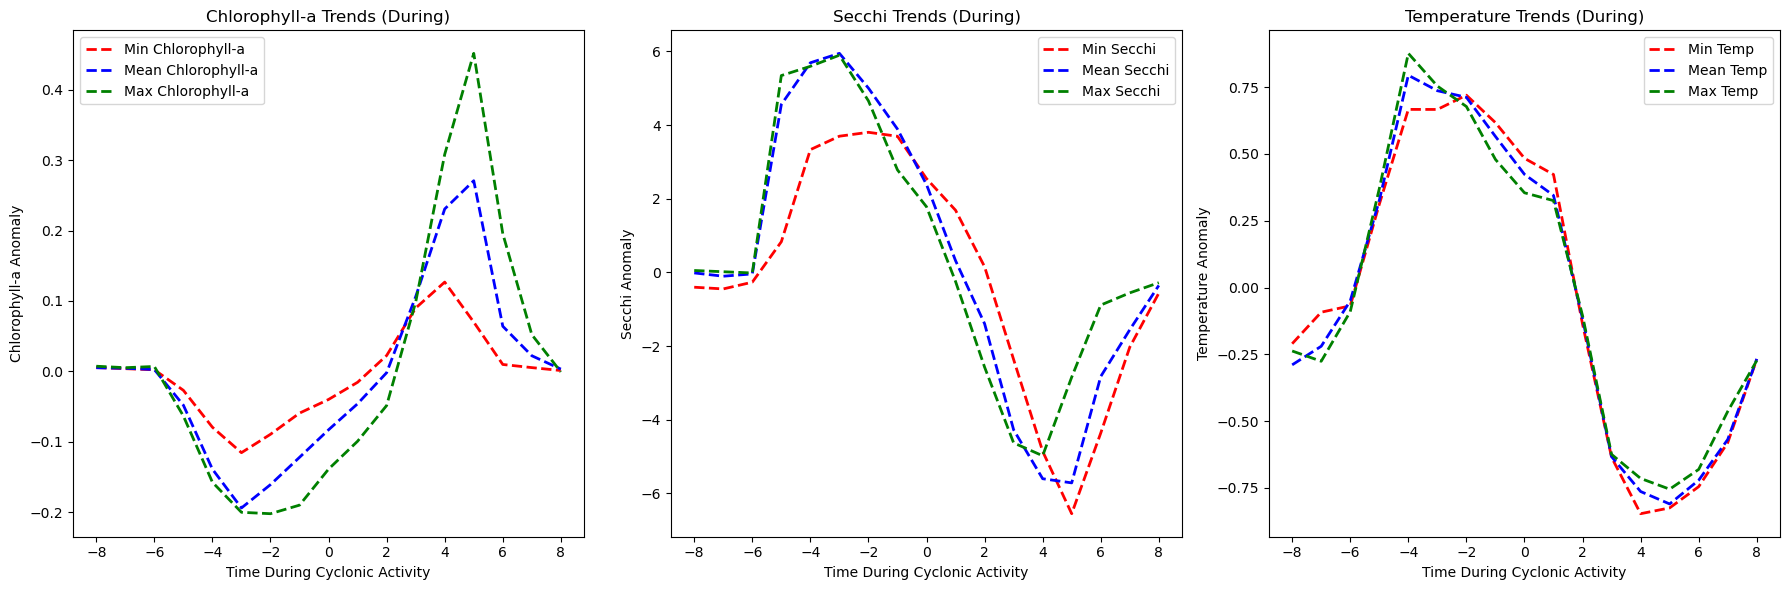

In [509]:
# Create a figure with 3 subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plotting the trendlines of Chlorophyll-a
axes[0].plot(min_chl[0], min_chl[1], "r--", lw=2, label="Min Chlorophyll-a")
axes[0].plot(mean_chl[0], mean_chl[1], "b--", lw=2, label="Mean Chlorophyll-a")
axes[0].plot(max_chl[0], max_chl[1], "g--", lw=2, label="Max Chlorophyll-a")
axes[0].set_title("Chlorophyll-a Trends (During)")
axes[0].legend()
axes[0].set_xlabel("Time During Cyclonic Activity")
axes[0].set_ylabel("Chlorophyll-a Anomaly")

# Plotting the trendlines of Secchi
axes[1].plot(min_se[0], min_se[1], "r--", lw=2, label="Min Secchi")
axes[1].plot(mean_se[0], mean_se[1], "b--", lw=2, label="Mean Secchi")
axes[1].plot(max_se[0], max_se[1], "g--", lw=2, label="Max Secchi")
axes[1].set_title("Secchi Trends (During)")
axes[1].legend()
axes[1].set_xlabel("Time During Cyclonic Activity")
axes[1].set_ylabel("Secchi Anomaly")

# Plotting the trendlines of temperature
axes[2].plot(min_t[0], min_t[1], "r--", lw=2, label="Min Temp")
axes[2].plot(mean_t[0], mean_t[1], "b--", lw=2, label="Mean Temp")
axes[2].plot(max_t[0], max_t[1], "g--", lw=2, label="Max Temp")
axes[2].set_title("Temperature Trends (During)")
axes[2].legend()
axes[2].set_xlabel("Time During Cyclonic Activity")
axes[2].set_ylabel("Temperature Anomaly")

# Adjust the layout so the plots don't overlap
plt.tight_layout()

# Display the figure
plt.show()

In [511]:
# Now we have all the anomalies plots for the duration of the cyclone for the three environmental variables.
# We can further investigate the variation by changing the plotting settings 
# We will not do that for all variables, but will only use temperature as an example:

In [513]:
# Adjusting the temperature graph with colours and point-size that correspond with the temp values

In [515]:
ids = np.where(new_norm_DURING['var_name']=='temp')[0]
norm_temp = new_norm_DURING.iloc[ids].copy().reset_index()
norm_temp

,index,Day 22,Day 23,Day 24,Day 25,Day 26,Day 27,Day 28,Day 29,Day 30,shift,stats,position,var_name
0,0,0.873369,0.725729,0.204662,-0.036639,-0.232582,-0.371746,-0.510089,-0.452247,-0.200460,0,Mean,pos4,temp
1,1,0.907550,0.870110,0.259690,-0.058093,-0.275710,-0.445943,-0.586116,-0.433856,-0.237628,0,Max,pos4,temp
2,2,0.750022,0.614011,0.097569,-0.026762,-0.170877,-0.322423,-0.414056,-0.398986,-0.128502,0,Min,pos4,temp
3,3,0.859840,0.745608,0.303134,-0.034892,-0.244647,-0.378079,-0.498807,-0.498820,-0.253339,0,Mean,pos5,temp
4,4,0.917824,0.880384,0.282123,-0.110039,-0.265436,-0.456383,-0.568619,-0.441441,-0.238414,0,Max,pos5,temp
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,64,-0.245240,-0.366978,-0.112997,-0.244864,0.659978,0.134358,0.313995,0.020553,-0.158806,-8,Max,pos35,temp
65,65,-0.405138,-0.244961,-0.203186,-0.201326,0.557785,0.130083,0.286947,0.157787,-0.077993,-8,Min,pos35,temp
66,66,-0.184803,-0.115885,0.043165,-0.244540,0.441106,0.206805,0.403155,-0.112561,-0.436442,-8,Mean,pos36,temp
67,67,-0.229290,-0.184528,-0.067047,-0.320437,0.422081,0.318567,0.464399,-0.048662,-0.355081,-8,Max,pos36,temp


/var/folders/hk/zsnq07m15bj1ldz1jnp2l_qc0000gn/T/ipykernel_72111/3415734593.py:20: RankWarning: Polyfit may be poorly conditioned
  fit = np.polyfit(xscatter[ind], yscatter[ind], deg=20)


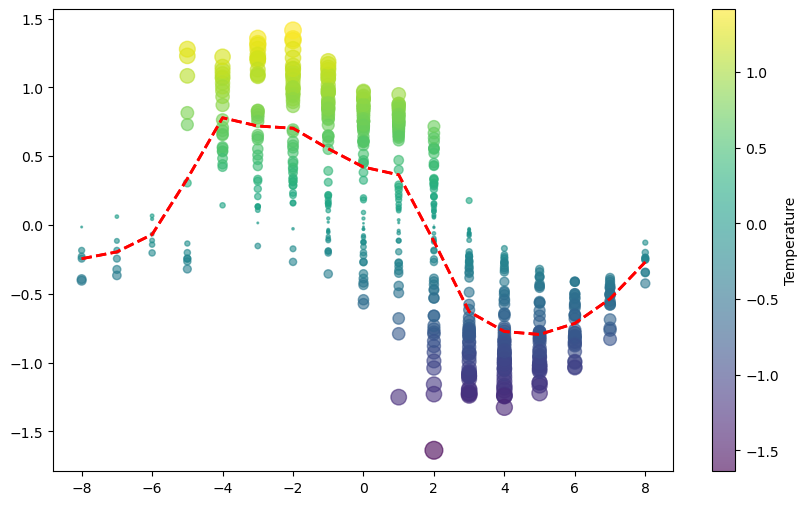

In [525]:
ids = np.where(new_norm_DURING['var_name']=='temp')[0]
norm_temp = new_norm_DURING.iloc[ids].copy().reset_index()

temp = []
shiftx = []
for pos in range(len(norm_temp)):
    tempval = norm_temp.iloc[pos].values[1:10]
    ishift = norm_temp['shift'].iloc[pos]
    x = np.arange(len(tempval))+ishift
    temp.append(tempval)
    shiftx.append(x)
plt.figure(figsize=(10, 6))

xscatter = np.asarray(shiftx, dtype=float).flatten()
yscatter = np.asarray(temp, dtype=float).flatten()

ind = np.argsort(xscatter)

# Adding the trendline using polyfit method 
fit = np.polyfit(xscatter[ind], yscatter[ind], deg=20) 
p = np.poly1d(fit) 
plt.plot(xscatter[ind],p(xscatter[ind]),"r--", lw=2) 

# Adjusting the map appearance 
scatter = plt.scatter(xscatter, yscatter, 
                      c=yscatter,                # Color: based on temperature (yscatter)
                      s=np.abs(yscatter) * 100,  # Size: proportional to temperature anomaly (times 100 to be large enough for display)
                      alpha=0.6,                 # Make points semi-transparent
                      cmap='viridis')            # Color map for warm/cold colors
# Add color bar
plt.colorbar(scatter, label='Temperature')

# Plot the fitted polynomial line
plt.plot(xscatter[ind], p(xscatter[ind]), "r--", lw=2)

plt.show()

In [451]:
# Re-adjusting the map so that each colour correspond to a specific position

/var/folders/hk/zsnq07m15bj1ldz1jnp2l_qc0000gn/T/ipykernel_72111/3466656024.py:23: RankWarning: Polyfit may be poorly conditioned
  fit = np.polyfit(xscatter[ind], yscatter[ind], deg=20)
/var/folders/hk/zsnq07m15bj1ldz1jnp2l_qc0000gn/T/ipykernel_72111/3466656024.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', 9)  # 9 discrete colors


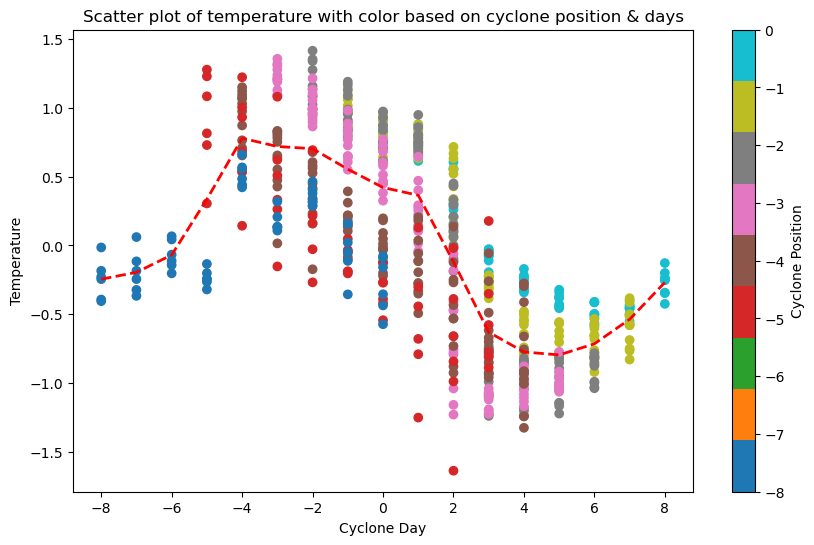

In [527]:
temp = []
shiftx = []
ishift_vals = []  # Store ishift values for coloring the points

# Loop to populate temp, shiftx, and ishift_vals
for pos in range(len(norm_temp)):
    tempval = norm_temp.iloc[pos].values[1:10]
    ishift = norm_temp['shift'].iloc[pos]
    x = np.arange(len(tempval)) + ishift
    temp.append(tempval)
    shiftx.append(x)
    ishift_vals.append(np.full_like(tempval, ishift))  # Store ishift value for each point

# Flatten the arrays for plotting
xscatter = np.asarray(shiftx, dtype=float).flatten()
yscatter = np.asarray(temp, dtype=float).flatten()
cscatter = np.asarray(ishift_vals, dtype=float).flatten()  # Use ishift for color

# Sorting index based on xscatter values
ind = np.argsort(xscatter)

# Fit polynomial to the data
fit = np.polyfit(xscatter[ind], yscatter[ind], deg=20)
p = np.poly1d(fit)

# Customize the scatter plot with color based on 'ishift' values
plt.figure(figsize=(10, 6))  # Optional: adjust figure size
cmap = plt.cm.get_cmap('tab10', 9)  # 9 discrete colors

# Create scatter plot with colors based on 'ishift' values
scatter = plt.scatter(xscatter, yscatter, 
                      c=cscatter,               # Color based on 'ishift' values
                      cmap=cmap,                # Use discrete colormap
                      )                         # Normalise colors to be discrete

# Add color bar to indicate 'ishift' intensity
plt.colorbar(scatter, label='Cyclone Position')

# Plot the fitted polynomial line
plt.plot(xscatter[ind], p(xscatter[ind]), "r--", lw=2)

# Customize plot labels and title
plt.xlabel('Cyclone Day')
plt.ylabel('Temperature')
plt.title('Scatter plot of temperature with color based on cyclone position & days')

# Show the plot
plt.show()


# Creating graphs with anomalies for the Before period:

In [529]:
combined_stats_BEFORE = pd.read_csv('combined_stats_BEFORE.csv')
combined_stats_BEFORE

,Unnamed: 0,var_name,position,stats,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,...,Day 12,Day 13,Day 14,Day 15,Day 16,Day 17,Day 18,Day 19,Day 20,Day 21
0,0,temp,pos4,Mean,29.545475,29.832327,29.904980,30.037544,30.336048,30.582610,...,30.170578,30.135859,30.342176,30.160973,30.097162,30.387506,30.723871,30.644203,30.382599,30.371740
1,1,temp,pos4,Max,29.721504,29.982054,30.097982,30.352020,30.494875,30.755377,...,30.395372,30.216700,30.459356,30.363330,30.195683,30.573431,30.969213,30.974930,30.724316,30.587366
2,2,temp,pos4,Min,29.286646,29.582176,29.706150,29.798850,30.130170,30.399452,...,29.903135,30.063448,30.222422,30.016632,30.007172,30.253279,30.401642,30.378696,30.246046,30.224642
3,3,temp,pos5,Mean,29.517980,29.762335,29.859703,29.948300,30.254803,30.552685,...,30.205742,30.152004,30.326840,30.201889,30.102520,30.468900,30.779860,30.710327,30.410824,30.352427
4,4,temp,pos5,Max,29.721504,29.982054,30.117926,30.307375,30.540840,30.820726,...,30.395372,30.264870,30.480740,30.420387,30.225150,30.688936,31.130383,30.943798,30.669891,30.582556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,202,Chl,pos35,Max,0.029038,0.027634,0.025081,0.028265,0.032324,0.031930,...,0.048381,0.046556,0.043724,0.042626,0.045318,0.042744,0.047472,0.040787,0.083113,0.075470
203,203,Chl,pos35,Min,0.020183,0.021320,0.019288,0.017746,0.018172,0.017650,...,0.020234,0.020228,0.022682,0.018433,0.020464,0.021751,0.021018,0.020392,0.023267,0.026021
204,204,Chl,pos36,Mean,0.029552,0.029112,0.028681,0.031548,0.031251,0.024817,...,0.046030,0.048220,0.049579,0.056631,0.054915,0.048329,0.044197,0.040439,0.038743,0.031530
205,205,Chl,pos36,Max,0.036832,0.034815,0.034480,0.041938,0.046589,0.041988,...,0.057982,0.058503,0.061815,0.079515,0.075104,0.074937,0.084160,0.070079,0.071206,0.056675


In [535]:
# Now, we move on the standardising the dataset
# Starting with calculating the average of each row to normalise the entire dataset 
combined_stats_BEFORE['Row_Average'] = combined_stats_BEFORE.iloc[:, 4:-1].mean(axis=1)
combined_stats_BEFORE

# Create a new DataFrame with the same first two columns
norm_BEFORE = combined_stats_BEFORE.copy()

# Subtract each entry from the row average for columns 4 to 25
standardized_columns = combined_stats_BEFORE.iloc[:, 4:-1].subtract(combined_stats_BEFORE['Row_Average'], axis=0)

# Add the standardised columns to the new DataFrame
standardized_columns['stats'] = norm_BEFORE['stats']
standardized_columns['position'] = norm_BEFORE['position']
standardized_columns['var_name'] = norm_BEFORE['var_name']
new_norm_BEFORE = standardized_columns.copy()
new_norm_BEFORE

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,...,Day 15,Day 16,Day 17,Day 18,Day 19,Day 20,Day 21,stats,position,var_name
0,-0.748232,-0.461380,-0.388727,-0.256163,0.042341,0.288903,-0.125902,-0.185953,0.408323,0.352941,...,-0.132734,-0.196545,0.093799,0.430164,0.350496,0.088892,0.078033,Mean,pos4,temp
1,-0.795402,-0.534852,-0.418924,-0.164886,-0.022031,0.238471,-0.111466,-0.216576,0.380318,0.676278,...,-0.153576,-0.321223,0.056525,0.452307,0.458024,0.207410,0.070460,Max,pos4,temp
2,-0.804964,-0.509434,-0.385460,-0.292760,0.038560,0.307842,-0.101389,-0.182352,0.439861,0.123552,...,-0.074978,-0.084438,0.161669,0.310032,0.287086,0.154436,0.133032,Min,pos4,temp
3,-0.788531,-0.544176,-0.446808,-0.358211,-0.051708,0.246174,-0.119673,-0.097494,0.428766,0.388552,...,-0.104622,-0.203991,0.162389,0.473349,0.403816,0.104313,0.045916,Mean,pos5,temp
4,-0.841034,-0.580484,-0.444612,-0.255163,-0.021698,0.258188,-0.036072,-0.055765,0.416161,0.630646,...,-0.142151,-0.337388,0.126398,0.567845,0.381260,0.107353,0.020018,Max,pos5,temp
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,-0.015200,-0.016604,-0.019157,-0.015973,-0.011914,-0.012308,0.002429,0.004716,0.001968,0.003314,...,-0.001612,0.001080,-0.001494,0.003234,-0.003451,0.038875,0.031232,Max,pos35,Chl
203,0.000025,0.001163,-0.000870,-0.002411,-0.001985,-0.002507,-0.002474,-0.001736,-0.001177,-0.000952,...,-0.001725,0.000307,0.001594,0.000861,0.000235,0.003109,0.005863,Min,pos35,Chl
204,-0.009475,-0.009914,-0.010346,-0.007478,-0.007775,-0.014210,-0.010034,-0.003994,-0.001790,0.001180,...,0.017604,0.015888,0.009302,0.005170,0.001412,-0.000284,-0.007497,Mean,pos36,Chl
205,-0.019580,-0.021598,-0.021933,-0.014475,-0.009824,-0.014425,-0.019435,-0.005072,-0.004655,0.002051,...,0.023102,0.018691,0.018524,0.027748,0.013666,0.014794,0.000262,Max,pos36,Chl


In [577]:
# Altering the function to match the Before dataset 

def get_indices(lst, targets):
    return list(filter(lambda x: lst[x] in targets, range(len(lst))))
    
def getVarStat(vname, stat):
    '''
    Extract from the dataframe the required values
    '''
    
    idx = get_indices(new_norm_BEFORE['var_name'], [vname])
    tmpdf = new_norm_BEFORE.iloc[idx].reset_index()
    del tmpdf['index']
    tmpdf
    
    idx = get_indices(tmpdf['stats'], [stat])
    tmpStat = tmpdf.iloc[idx].reset_index()
    del tmpStat['index']
    
    return tmpStat

# Creating a function to generate the trendlines of the anomalies 

def getTrend(df):
    tmp = []
    x = []
    for pos in range(len(df)):
        tmpval = df.iloc[pos].values[0:21]
        x = np.arange(len(tmpval))
        tmp.append(tmpval)
    xscatter = np.asarray(x, dtype=float).flatten()
    yscatter = np.asarray(tmp, dtype=float).flatten()
    ind = np.argsort(xscatter)
    fit = np.polyfit(xscatter[ind], yscatter[ind], deg=20) 
    p = np.poly1d(fit) 

    return [xscatter[ind],p(xscatter[ind])]

# Creating a function to plot scatter plots & trendlines of the anomalies 

def plotVarStat(df):
    tmp = []
    x = []
    for pos in range(len(df)):
        tmpval = df.iloc[pos].values[0:21]
        x = np.arange(len(tmpval))
        tmp.append(tmpval)
        plt.scatter(x, tmpval)
    xscatter = np.asarray(x, dtype=float).flatten()
    yscatter = np.asarray(tmp, dtype=float).flatten()
    ind = np.argsort(xscatter)
    fit = np.polyfit(xscatter[ind], yscatter[ind], deg=20) 
    p = np.poly1d(fit) 
    plt.plot(xscatter[ind],p(xscatter[ind]),"r--", lw=2) 
    plt.show()

    return [xscatter[ind],p(xscatter[ind])]

In [579]:
chl_minB = getVarStat('Chl','Min')
chl_meanB = getVarStat('Chl','Mean')
chl_maxB = getVarStat('Chl','Max')

temp_minB = getVarStat('temp','Min')
temp_meanB = getVarStat('temp','Mean')
temp_maxB = getVarStat('temp','Max')

Secchi_minB = getVarStat('Secchi','Min')
Secchi_meanB = getVarStat('Secchi','Mean')
Secchi_maxB = getVarStat('Secchi','Max')

In [581]:
min_chlB = getTrend(chl_minB)
mean_chlB = getTrend(chl_meanB)
max_chlB = getTrend(chl_maxB)

min_tB = getTrend(temp_minB)
mean_tB = getTrend(temp_meanB)
max_tB = getTrend(temp_maxB)

min_seB = getTrend(Secchi_minB)
mean_seB = getTrend(Secchi_meanB)
max_seB = getTrend(Secchi_maxB)

/var/folders/hk/zsnq07m15bj1ldz1jnp2l_qc0000gn/T/ipykernel_72111/2578420213.py:34: RankWarning: Polyfit may be poorly conditioned
  fit = np.polyfit(xscatter[ind], yscatter[ind], deg=20)
/var/folders/hk/zsnq07m15bj1ldz1jnp2l_qc0000gn/T/ipykernel_72111/2578420213.py:34: RankWarning: Polyfit may be poorly conditioned
  fit = np.polyfit(xscatter[ind], yscatter[ind], deg=20)
/var/folders/hk/zsnq07m15bj1ldz1jnp2l_qc0000gn/T/ipykernel_72111/2578420213.py:34: RankWarning: Polyfit may be poorly conditioned
  fit = np.polyfit(xscatter[ind], yscatter[ind], deg=20)
/var/folders/hk/zsnq07m15bj1ldz1jnp2l_qc0000gn/T/ipykernel_72111/2578420213.py:34: RankWarning: Polyfit may be poorly conditioned
  fit = np.polyfit(xscatter[ind], yscatter[ind], deg=20)
/var/folders/hk/zsnq07m15bj1ldz1jnp2l_qc0000gn/T/ipykernel_72111/2578420213.py:34: RankWarning: Polyfit may be poorly conditioned
  fit = np.polyfit(xscatter[ind], yscatter[ind], deg=20)
/var/folders/hk/zsnq07m15bj1ldz1jnp2l_qc0000gn/T/ipykernel_72111/

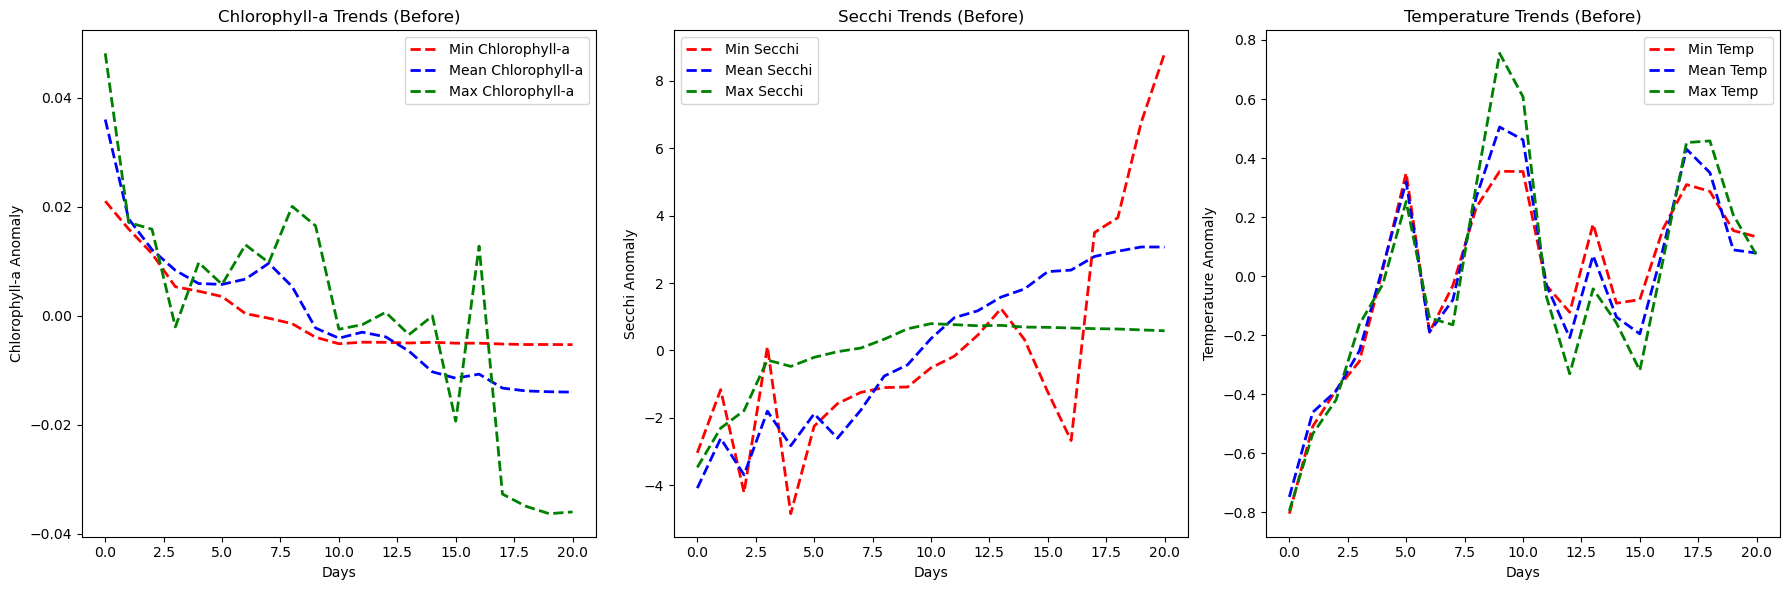

In [585]:
# Create a figure with 3 subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plotting the trendlines of Chlorophyll-a
axes[0].plot(min_chlB[0], min_chlB[1], "r--", lw=2, label="Min Chlorophyll-a")
axes[0].plot(mean_chlB[0], mean_chlB[1], "b--", lw=2, label="Mean Chlorophyll-a")
axes[0].plot(max_chlB[0], max_chlB[1], "g--", lw=2, label="Max Chlorophyll-a")
axes[0].set_title("Chlorophyll-a Trends (Before)")
axes[0].legend()
axes[0].set_xlabel("Days")
axes[0].set_ylabel("Chlorophyll-a Anomaly")

# Plotting the trendlines of Secchi
axes[1].plot(min_seB[0], min_seB[1], "r--", lw=2, label="Min Secchi")
axes[1].plot(mean_seB[0], mean_seB[1], "b--", lw=2, label="Mean Secchi")
axes[1].plot(max_seB[0], max_seB[1], "g--", lw=2, label="Max Secchi")
axes[1].set_title("Secchi Trends (Before)")
axes[1].legend()
axes[1].set_xlabel("Days")
axes[1].set_ylabel("Secchi Anomaly")

# Plotting the trendlines of temperature
axes[2].plot(min_tB[0], min_tB[1], "r--", lw=2, label="Min Temp")
axes[2].plot(mean_tB[0], mean_tB[1], "b--", lw=2, label="Mean Temp")
axes[2].plot(max_tB[0], max_tB[1], "g--", lw=2, label="Max Temp")
axes[2].set_title("Temperature Trends (Before)")
axes[2].legend()
axes[2].set_xlabel("Days")
axes[2].set_ylabel("Temperature Anomaly")

# Adjust the layout so the plots don't overlap
plt.tight_layout()

# Display the figure
plt.show()

# Creating graphs with anomalies for the After period:

In [588]:
# Loding the cvs with all the stats for all positions and stats for During the cyclone period 
combined_stats_AFTER = pd.read_csv('combined_stats_AFTER.csv')
combined_stats_AFTER

,Unnamed: 0,var_name,position,stats,Day 31,Day 32,Day 33,Day 34,Day 35,Day 36,...,Day 43,Day 44,Day 45,Day 46,Day 47,Day 48,Day 49,Day 50,Day 51,Day 52
0,0,temp,pos4,Mean,29.524303,29.461824,29.185827,29.103344,29.094456,29.125504,...,28.957668,29.255417,28.959753,28.934351,28.954609,28.743603,28.695757,28.702540,28.719805,28.707952
1,1,temp,pos4,Max,29.742481,29.783718,29.312428,29.398335,29.310862,29.352186,...,29.125450,29.469837,29.136955,29.115461,29.143010,28.895136,28.868390,28.875546,28.990524,29.040077
2,2,temp,pos4,Min,29.303620,29.259352,28.948835,28.772630,28.792786,28.783375,...,28.886324,29.043863,28.778446,28.740602,28.710018,28.615911,28.544220,28.445950,28.523098,28.470590
3,3,temp,pos5,Mean,29.407173,29.309130,29.150063,28.996784,28.964016,28.999443,...,28.909962,29.098219,28.860370,28.816100,28.827497,28.730782,28.631142,28.548365,28.556920,28.529724
4,4,temp,pos5,Max,29.625824,29.533455,29.268225,29.227575,29.204342,29.204233,...,29.124002,29.335700,29.010574,28.998184,29.094818,28.851795,28.824785,28.829636,28.793621,28.790546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,202,Chl,pos35,Max,0.050139,0.075354,0.076196,0.149445,0.179486,0.156263,...,0.095090,0.090063,0.089985,0.096341,0.106278,0.108281,0.092855,0.091042,0.085142,0.070077
203,203,Chl,pos35,Min,0.032928,0.043738,0.050649,0.055550,0.056719,0.054794,...,0.038696,0.037196,0.038256,0.038202,0.038159,0.039021,0.039991,0.041459,0.043528,0.041739
204,204,Chl,pos36,Mean,0.039756,0.066008,0.117669,0.120972,0.094148,0.086766,...,0.124942,0.114528,0.102759,0.075054,0.062919,0.065821,0.064889,0.068187,0.069966,0.078630
205,205,Chl,pos36,Max,0.045006,0.078931,0.152891,0.171707,0.156962,0.122034,...,0.209715,0.270082,0.255404,0.195269,0.128603,0.152264,0.167157,0.182100,0.187512,0.190625


## Now, we move on the standardising the dataset

In [594]:
# Starting with calculating the average of each row to normalise the entire dataset 
combined_stats_AFTER['Row_Average'] = combined_stats_AFTER.iloc[:, 4:-1].mean(axis=1)
combined_stats_AFTER

# Create a new DataFrame with the same first two columns
norm_AFTER = combined_stats_AFTER.copy()

# Subtract each entry from the row average for columns 4 to 25
standardized_columns = combined_stats_AFTER.iloc[:, 4:-1].subtract(combined_stats_AFTER['Row_Average'], axis=0)

# Add the standardised columns to the new DataFrame
standardized_columns['stats'] = norm_AFTER['stats']
standardized_columns['position'] = norm_AFTER['position']
standardized_columns['var_name'] = norm_AFTER['var_name']
new_norm_AFTER = standardized_columns.copy()
new_norm_AFTER

,Day 31,Day 32,Day 33,Day 34,Day 35,Day 36,Day 37,Day 38,Day 39,Day 40,...,Day 46,Day 47,Day 48,Day 49,Day 50,Day 51,Day 52,stats,position,var_name
0,0.470346,0.407867,0.131870,0.049387,0.040499,0.071547,0.085184,0.086423,0.040773,0.021709,...,-0.119606,-0.099348,-0.310354,-0.358200,-0.351417,-0.334152,-0.346005,Mean,pos4,temp
1,0.508961,0.550198,0.078908,0.164815,0.077342,0.118666,0.041667,-0.005584,-0.024991,-0.048357,...,-0.118059,-0.090510,-0.338384,-0.365130,-0.357974,-0.242996,-0.193443,Max,pos4,temp
2,0.450224,0.405956,0.095439,-0.080766,-0.060610,-0.070021,0.017200,0.048726,0.120845,0.086704,...,-0.112794,-0.143378,-0.237485,-0.309176,-0.407446,-0.330298,-0.382806,Min,pos4,temp
3,0.449094,0.351051,0.191984,0.038705,0.005937,0.041364,0.077716,0.088285,0.059495,0.087211,...,-0.141979,-0.130582,-0.227297,-0.326937,-0.409714,-0.401159,-0.428355,Mean,pos5,temp
4,0.462318,0.369949,0.104719,0.064069,0.040836,0.040727,0.089410,0.080579,0.045023,0.199829,...,-0.165322,-0.068688,-0.311711,-0.338721,-0.333870,-0.369885,-0.372960,Max,pos5,temp
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,-0.049392,-0.024177,-0.023335,0.049913,0.079954,0.056731,0.026696,0.001950,-0.010410,-0.014673,...,-0.003190,0.006747,0.008750,-0.006676,-0.008490,-0.014390,-0.029454,Max,pos35,Chl
203,-0.010959,-0.000149,0.006762,0.011663,0.012832,0.010907,0.010656,0.006312,0.002981,-0.001470,...,-0.005685,-0.005728,-0.004865,-0.003896,-0.002428,-0.000359,-0.002147,Min,pos35,Chl
204,-0.043718,-0.017466,0.034195,0.037498,0.010673,0.003292,-0.011584,-0.014395,0.003357,0.005430,...,-0.008420,-0.020555,-0.017653,-0.018585,-0.015287,-0.013509,-0.004844,Mean,pos36,Chl
205,-0.103464,-0.069539,0.004420,0.023236,0.008491,-0.026437,-0.049743,-0.038768,-0.025280,-0.034368,...,0.046799,-0.019868,0.003793,0.018686,0.033629,0.039041,0.042154,Max,pos36,Chl


In [596]:
# Altering the function to match the Before dataset 

def get_indices(lst, targets):
    return list(filter(lambda x: lst[x] in targets, range(len(lst))))
    
def getVarStat(vname, stat):
    '''
    Extract from the dataframe the required values
    '''
    
    idx = get_indices(new_norm_AFTER['var_name'], [vname])
    tmpdf = new_norm_AFTER.iloc[idx].reset_index()
    del tmpdf['index']
    tmpdf
    
    idx = get_indices(tmpdf['stats'], [stat])
    tmpStat = tmpdf.iloc[idx].reset_index()
    del tmpStat['index']
    
    return tmpStat

# Creating a function to generate the trendlines of the anomalies 

def getTrend(df):
    tmp = []
    x = []
    for pos in range(len(df)):
        tmpval = df.iloc[pos].values[0:-4]
        x = np.arange(len(tmpval))
        tmp.append(tmpval)
    xscatter = np.asarray(x, dtype=float).flatten()
    yscatter = np.asarray(tmp, dtype=float).flatten()
    ind = np.argsort(xscatter)
    fit = np.polyfit(xscatter[ind], yscatter[ind], deg=20) 
    p = np.poly1d(fit) 

    return [xscatter[ind],p(xscatter[ind])]

# Creating a function to plot scatter plots & trendlines of the anomalies 

def plotVarStat(df):
    tmp = []
    x = []
    for pos in range(len(df)):
        tmpval = df.iloc[pos].values[0:-4]
        x = np.arange(len(tmpval))
        tmp.append(tmpval)
        plt.scatter(x, tmpval)
    xscatter = np.asarray(x, dtype=float).flatten()
    yscatter = np.asarray(tmp, dtype=float).flatten()
    ind = np.argsort(xscatter)
    fit = np.polyfit(xscatter[ind], yscatter[ind], deg=20) 
    p = np.poly1d(fit) 
    plt.plot(xscatter[ind],p(xscatter[ind]),"r--", lw=2) 
    plt.show()

    return [xscatter[ind],p(xscatter[ind])]

In [600]:
chl_minA = getVarStat('Chl','Min')
chl_meanA = getVarStat('Chl','Mean')
chl_maxA = getVarStat('Chl','Max')

temp_minA = getVarStat('temp','Min')
temp_meanA = getVarStat('temp','Mean')
temp_maxA = getVarStat('temp','Max')

Secchi_minA = getVarStat('Secchi','Min')
Secchi_meanA = getVarStat('Secchi','Mean')
Secchi_maxA = getVarStat('Secchi','Max')

In [602]:
min_chlA = getTrend(chl_minA)
mean_chlA = getTrend(chl_meanA)
max_chlA = getTrend(chl_maxA)

min_tA = getTrend(temp_minA)
mean_tA = getTrend(temp_meanA)
max_tA = getTrend(temp_maxA)

min_seA = getTrend(Secchi_minA)
mean_seA = getTrend(Secchi_meanA)
max_seA = getTrend(Secchi_maxA)

/var/folders/hk/zsnq07m15bj1ldz1jnp2l_qc0000gn/T/ipykernel_72111/3020096871.py:34: RankWarning: Polyfit may be poorly conditioned
  fit = np.polyfit(xscatter[ind], yscatter[ind], deg=20)
/var/folders/hk/zsnq07m15bj1ldz1jnp2l_qc0000gn/T/ipykernel_72111/3020096871.py:34: RankWarning: Polyfit may be poorly conditioned
  fit = np.polyfit(xscatter[ind], yscatter[ind], deg=20)
/var/folders/hk/zsnq07m15bj1ldz1jnp2l_qc0000gn/T/ipykernel_72111/3020096871.py:34: RankWarning: Polyfit may be poorly conditioned
  fit = np.polyfit(xscatter[ind], yscatter[ind], deg=20)
/var/folders/hk/zsnq07m15bj1ldz1jnp2l_qc0000gn/T/ipykernel_72111/3020096871.py:34: RankWarning: Polyfit may be poorly conditioned
  fit = np.polyfit(xscatter[ind], yscatter[ind], deg=20)
/var/folders/hk/zsnq07m15bj1ldz1jnp2l_qc0000gn/T/ipykernel_72111/3020096871.py:34: RankWarning: Polyfit may be poorly conditioned
  fit = np.polyfit(xscatter[ind], yscatter[ind], deg=20)
/var/folders/hk/zsnq07m15bj1ldz1jnp2l_qc0000gn/T/ipykernel_72111/

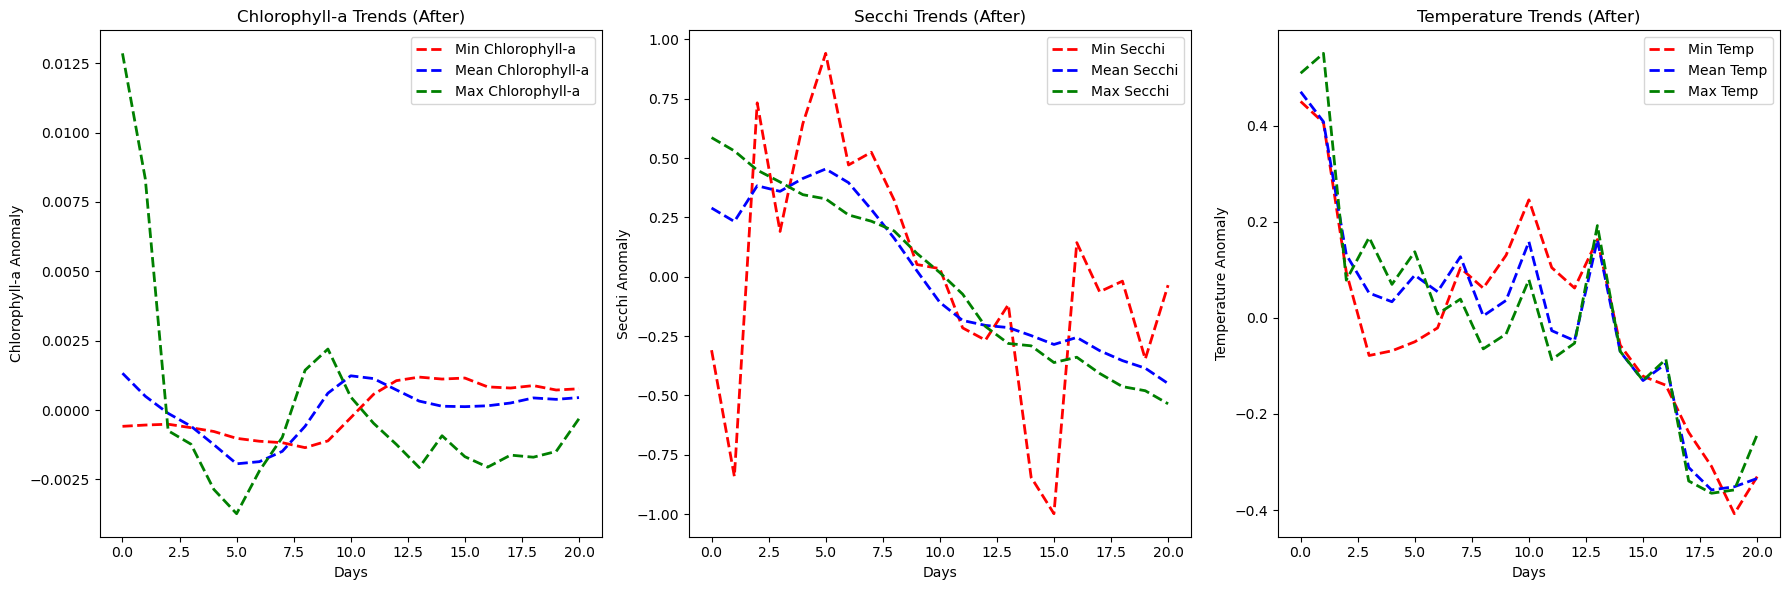

In [608]:
# Create a figure with 3 subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plotting the trendlines of Chlorophyll-a
axes[0].plot(min_chlA[0], min_chlA[1], "r--", lw=2, label="Min Chlorophyll-a")
axes[0].plot(mean_chlA[0], mean_chlA[1], "b--", lw=2, label="Mean Chlorophyll-a")
axes[0].plot(max_chlA[0], max_chlA[1], "g--", lw=2, label="Max Chlorophyll-a")
axes[0].set_title("Chlorophyll-a Trends (After)")
axes[0].legend()
axes[0].set_xlabel("Days")
axes[0].set_ylabel("Chlorophyll-a Anomaly")

# Plotting the trendlines of Secchi
axes[1].plot(min_seA[0], min_seA[1], "r--", lw=2, label="Min Secchi")
axes[1].plot(mean_seA[0], mean_seA[1], "b--", lw=2, label="Mean Secchi")
axes[1].plot(max_seA[0], max_seA[1], "g--", lw=2, label="Max Secchi")
axes[1].set_title("Secchi Trends (After)")
axes[1].legend()
axes[1].set_xlabel("Days")
axes[1].set_ylabel("Secchi Anomaly")

# Plotting the trendlines of temperature
axes[2].plot(min_tA[0], min_tA[1], "r--", lw=2, label="Min Temp")
axes[2].plot(mean_tA[0], mean_tA[1], "b--", lw=2, label="Mean Temp")
axes[2].plot(max_tA[0], max_tA[1], "g--", lw=2, label="Max Temp")
axes[2].set_title("Temperature Trends (After)")
axes[2].legend()
axes[2].set_xlabel("Days")
axes[2].set_ylabel("Temperature Anomaly")

# Adjust the layout so the plots don't overlap
plt.tight_layout()

# Display the figure
plt.show()